# Inspect Vesicle Training Data


In [1]:
import os

code_path = os.path.abspath("../../")
os.chdir(code_path)

import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/nucleus"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

Using TensorFlow backend.


In [2]:
os.chdir(os.path.join(code_path, 'samples/vesicles'))


import vesicle

%matplotlib inline 

In [3]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [4]:
# Dataset directory
DATASET_DIR = code_path = os.path.abspath("../../../data")

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(vesicle.Config):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Navigate to the dataset from the VesicleSegmentation directory.

In [6]:
# Load dataset
dataset = vesicle.VesicleDataset()
# The subset is the name of the sub-directory, such as threeD_train, threeD_valid, threeD_test

dataset.load_vesicle(DATASET_DIR, subset="threeD_valid")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 12
Class Count: 3
  0. BG                                                
  1. vesicles                                          
  2. mitochondria                                      


## Display Samples

11


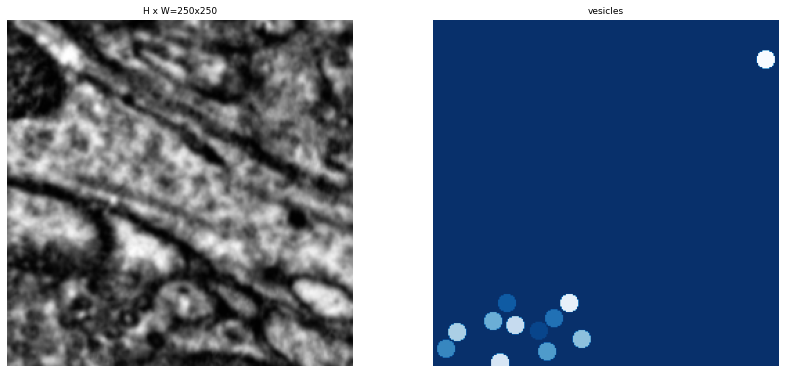

6


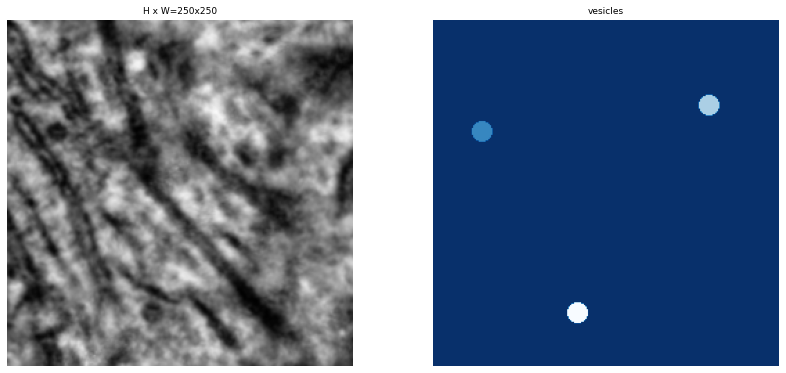

6


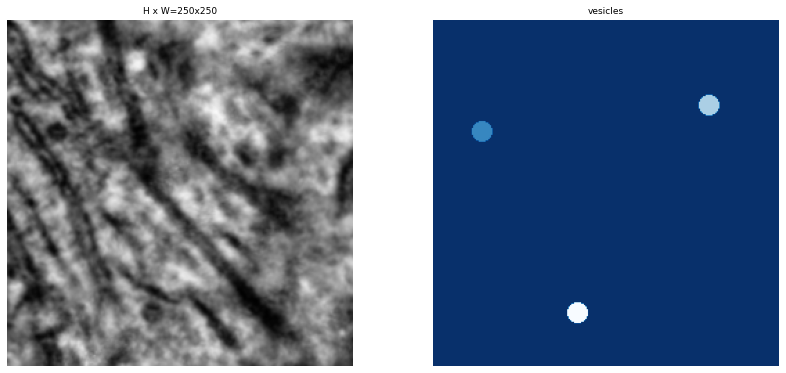

0


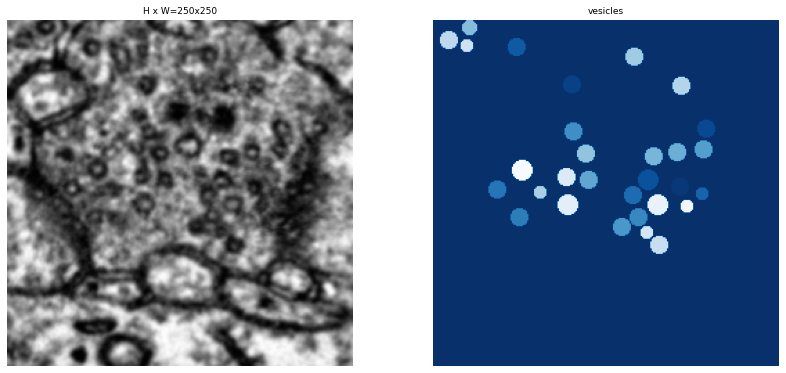

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (250, 250, 3)         min:    1.00000  max:  254.00000  uint8
mask                     shape: (250, 250, 30)        min:    0.00000  max:    1.00000  bool


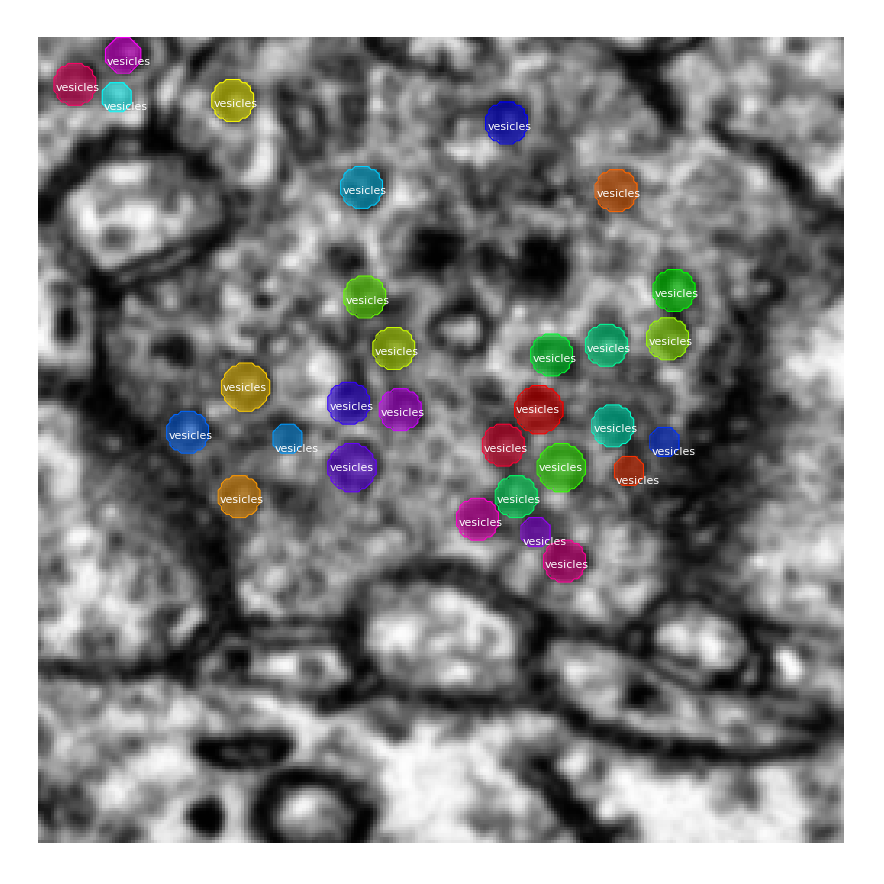

In [8]:
# Example of loading a specific image by its source ID
source_id = "vesicle.250_003"

# Map source ID to Dataset image_id
# Notice the vesicle prefix: it's the name given to the dataset in VesicleDataset
image_id = dataset.image_from_source_map[source_id]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [9]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 0.1 seconds


### Image Size Stats

Image Count:  12
Height  mean: 250.00  median: 250.00  min: 250.00  max: 250.00
Width   mean: 250.00  median: 250.00  min: 250.00  max: 250.00
Color   mean (RGB): 108.68 108.68 108.68


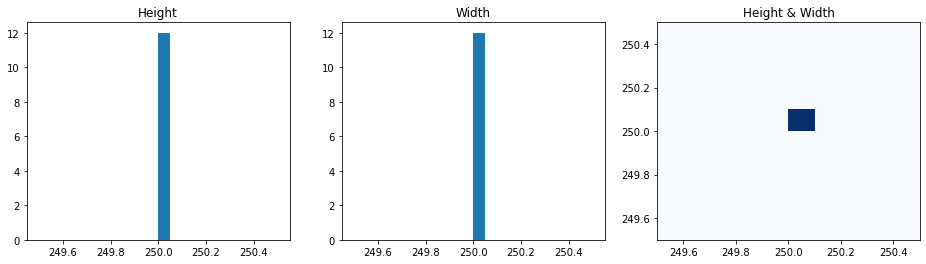

In [10]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Nuclei per Image Stats

Nuclei/Image
Image area <=  256**2:  mean: 13.6  median: 11.0  min: 1.0  max: 44.0
Image area <= 600.0**2: None
Image area <= 1300.0**2: None


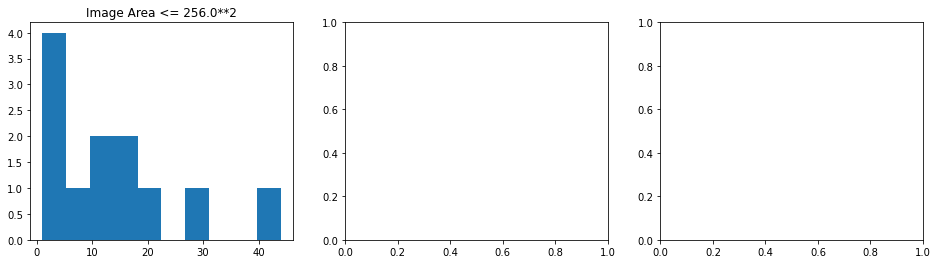

In [11]:
# Segment by image area
image_area_bins = [256**2, 600**2, 1300**2]

print("Nuclei/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    vesicle_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) ])
    area_threshold = image_area
    if len(vesicle_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), vesicle_per_image.mean(), np.median(vesicle_per_image), 
        vesicle_per_image.min(), vesicle_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(vesicle_per_image, bins=10)

In [12]:
def gen_shape(image_area, area_threshold = 0):
    ls = []
    for s in stats:
        if area_threshold < s['shape'][0] * s['shape'][1]:
            for b in s['bbox']:
                ls.append(b)
    return np.array(ls)

for i, image_area in enumerate(image_area_bins):
    
    vesicle_shape = gen_shape(image_area, area_threshold = 0)

    vesicle_area = vesicle_shape[:, 0] * vesicle_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Vesicle: ", vesicle_shape.shape[0])
    print("  Vesicle Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(vesicle_shape[:, 0]), np.median(vesicle_shape[:, 0]),
        np.min(vesicle_shape[:, 0]), np.max(vesicle_shape[:, 0])))
    print("  Vesicle Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(vesicle_shape[:, 1]), np.median(vesicle_shape[:, 1]),
        np.min(vesicle_shape[:, 1]), np.max(vesicle_shape[:, 1])))
    print("  Vesicle Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(vesicle_area), np.median(vesicle_area),
        np.min(vesicle_area), np.max(vesicle_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(vesicle_shape[:, 1], vesicle_shape[:, 0], bins=20, cmap="Blues")
    


Image Area <= 256**2
  Total Vesicle:  163
  Vesicle Height. mean: 18.71  median: 13.00  min: 9.00  max: 250.00
  Vesicle Width.  mean: 17.45  median: 13.00  min: 9.00  max: 181.00
  Vesicle Area.   mean: 1006.71  median: 169.00  min: 81.00  max: 41750.00

Image Area <= 600**2
  Total Vesicle:  163
  Vesicle Height. mean: 18.71  median: 13.00  min: 9.00  max: 250.00
  Vesicle Width.  mean: 17.45  median: 13.00  min: 9.00  max: 181.00
  Vesicle Area.   mean: 1006.71  median: 169.00  min: 81.00  max: 41750.00

Image Area <= 1300**2
  Total Vesicle:  163
  Vesicle Height. mean: 18.71  median: 13.00  min: 9.00  max: 250.00
  Vesicle Width.  mean: 17.45  median: 13.00  min: 9.00  max: 181.00
  Vesicle Area.   mean: 1006.71  median: 169.00  min: 81.00  max: 41750.00



Image Area <= 256**2
  Total vesicle:  163
  vesicle Height. mean: 18.71  median: 13.00  min: 9.00  max: 250.00
  vesicle Width.  mean: 17.45  median: 13.00  min: 9.00  max: 181.00
  vesicle Area.   mean: 1006.71  median: 169.00  min: 81.00  max: 41750.00


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

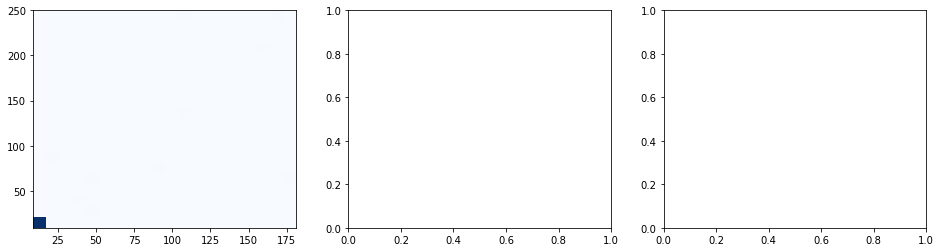

In [15]:
# Vesicle size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    vesicle_shape = np.array([
        b 
        for s in stats if area_threshold < s['shape'][0] * s['shape'][1]
        for b in s['bbox']])
    vesicle_area = vesicle_shape[:, 0] * vesicle_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total vesicle: ", vesicle_shape.shape[0])
    print("  vesicle Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(vesicle_shape[:, 0]), np.median(vesicle_shape[:, 0]),
        np.min(vesicle_shape[:, 0]), np.max(vesicle_shape[:, 0])))
    print("  vesicle Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(vesicle_shape[:, 1]), np.median(vesicle_shape[:, 1]),
        np.min(vesicle_shape[:, 1]), np.max(vesicle_shape[:, 1])))
    print("  vesicle Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(vesicle_area), np.median(vesicle_area),
        np.min(vesicle_area), np.max(vesicle_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(vesicle_shape[:, 1], vesicle_shape[:, 0], bins=20, cmap="Blues")

In [ ]:
# Nuclei height/width ratio
vesicle_aspect_ratio = vesicle_shape[:, 0] / vesicle_shape[:, 1]
print("Vesicle Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(vesicle_aspect_ratio), np.median(vesicle_aspect_ratio),
    np.min(vesicle_aspect_ratio), np.max(vesicle_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(vesicle_aspect_ratio, bins=100, range=[0, 5])

## Image Augmentation

Test out different augmentation methods

In [ ]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Image Crops

Microscoy images tend to be large, but nuclei are small. So it's more efficient to train on random crops from large images. This is handled by `config.IMAGE_RESIZE_MODE = "crop"`.



In [16]:
class RandomCropConfig(vesicle.VesicleConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

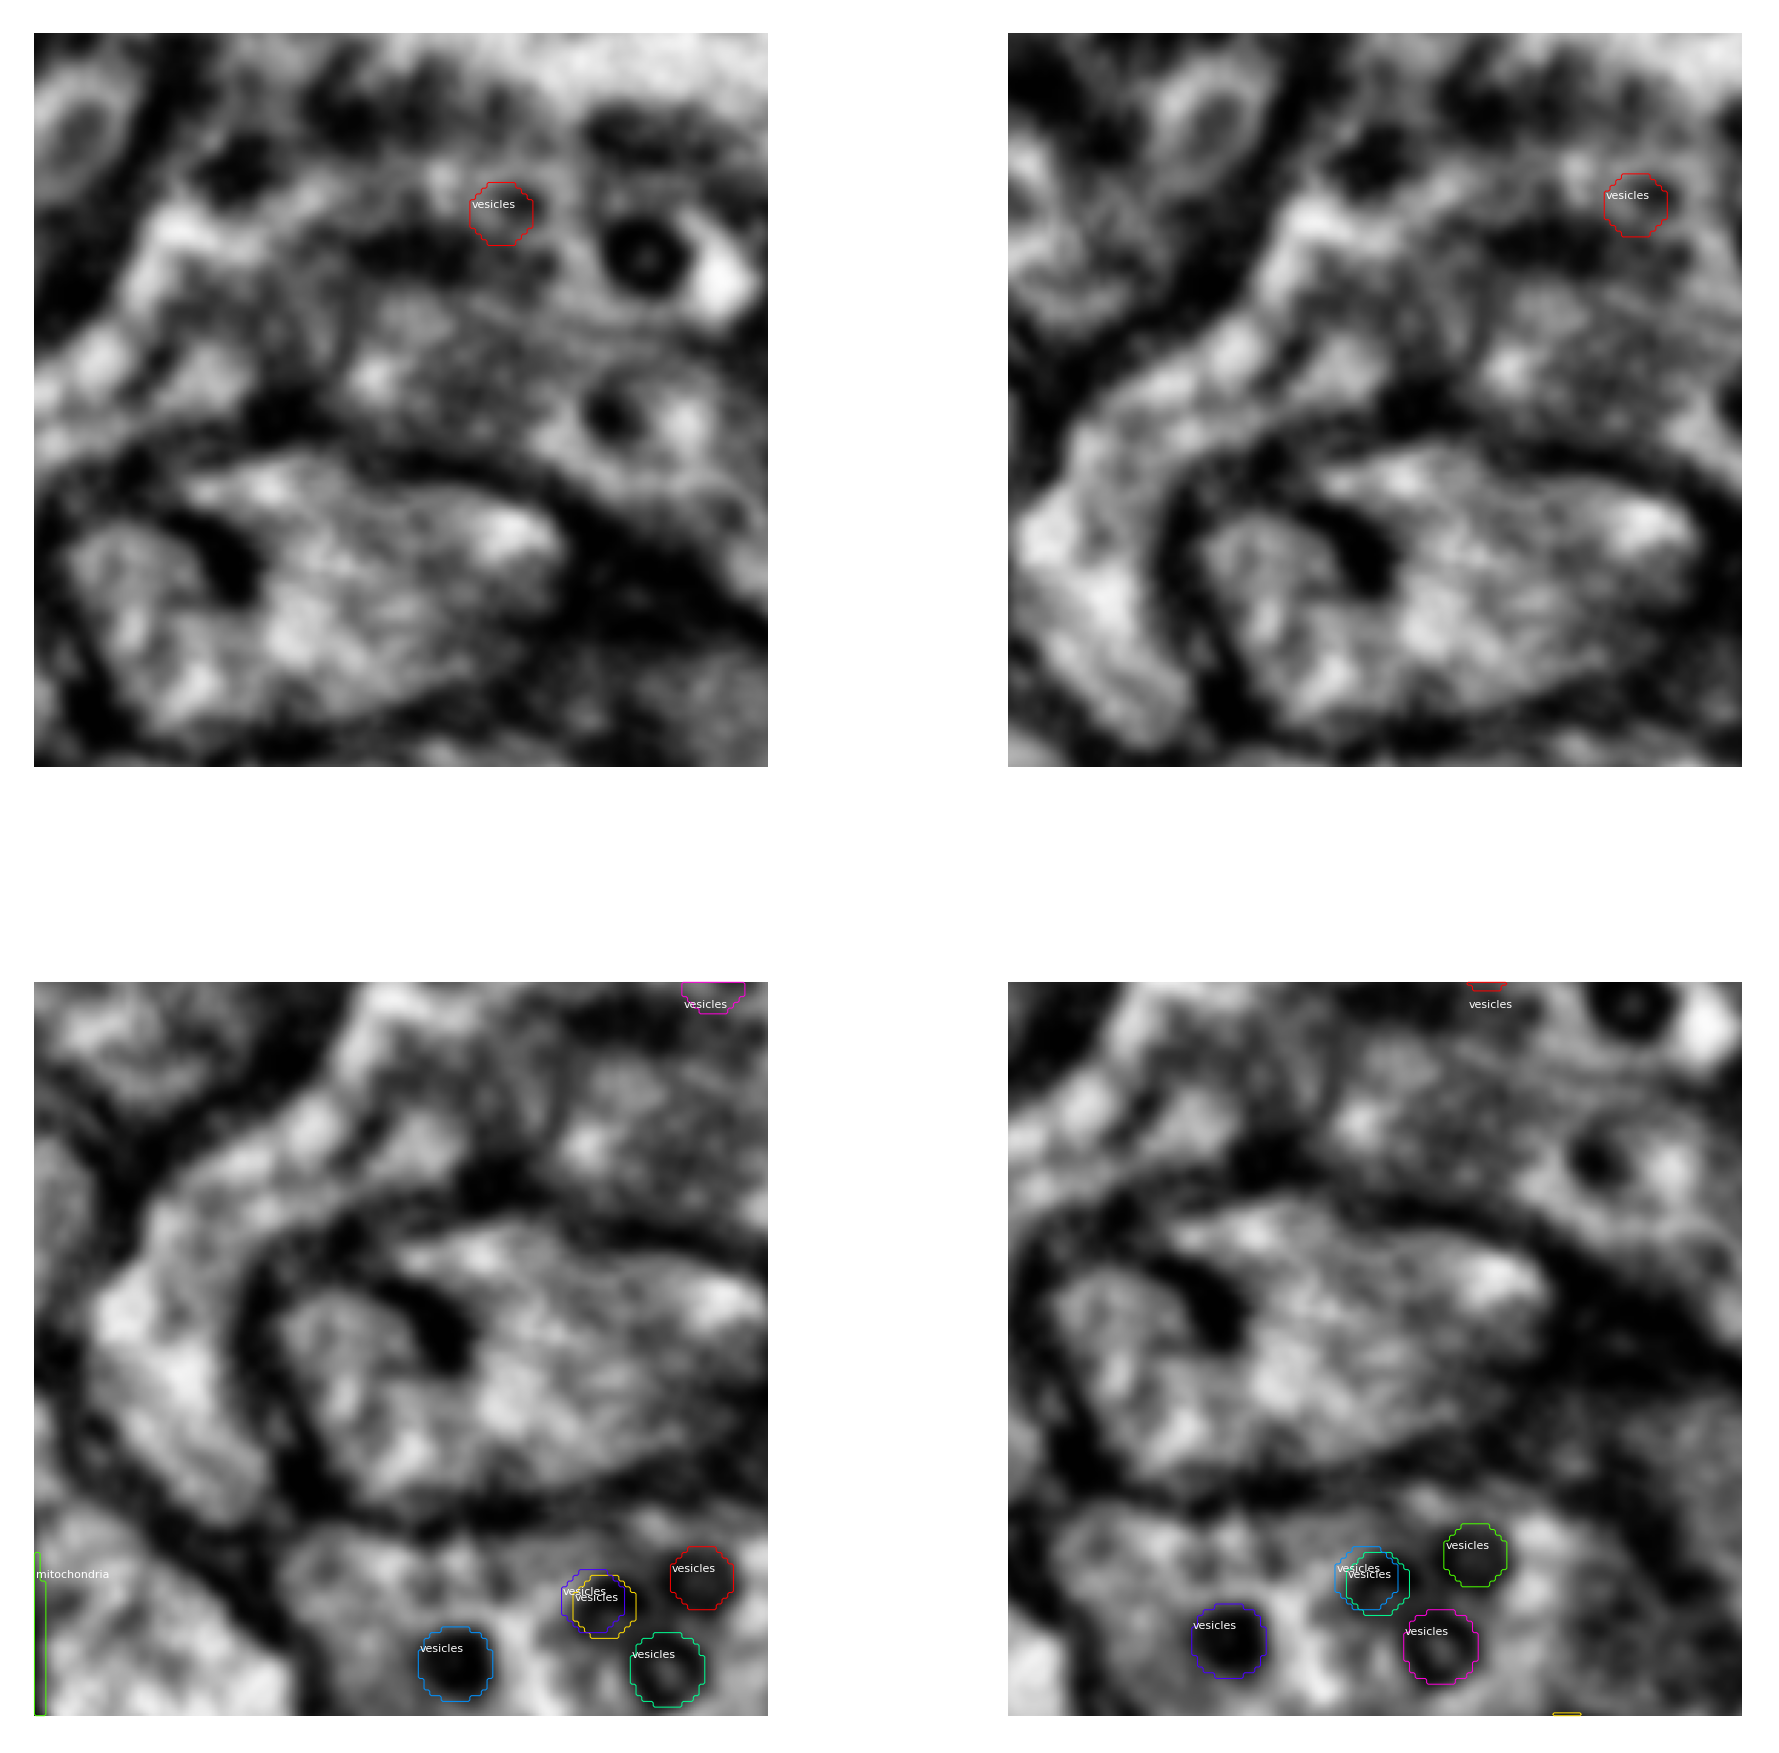

In [17]:
# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image_id:  1 250_039
Original shape:  (250, 250, 3)
image                    shape: (250, 250, 3)         min:    1.00000  max:  255.00000  uint8
mask                     shape: (250, 250, 15)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (15,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (15, 4)               min:    0.00000  max:  250.00000  int32


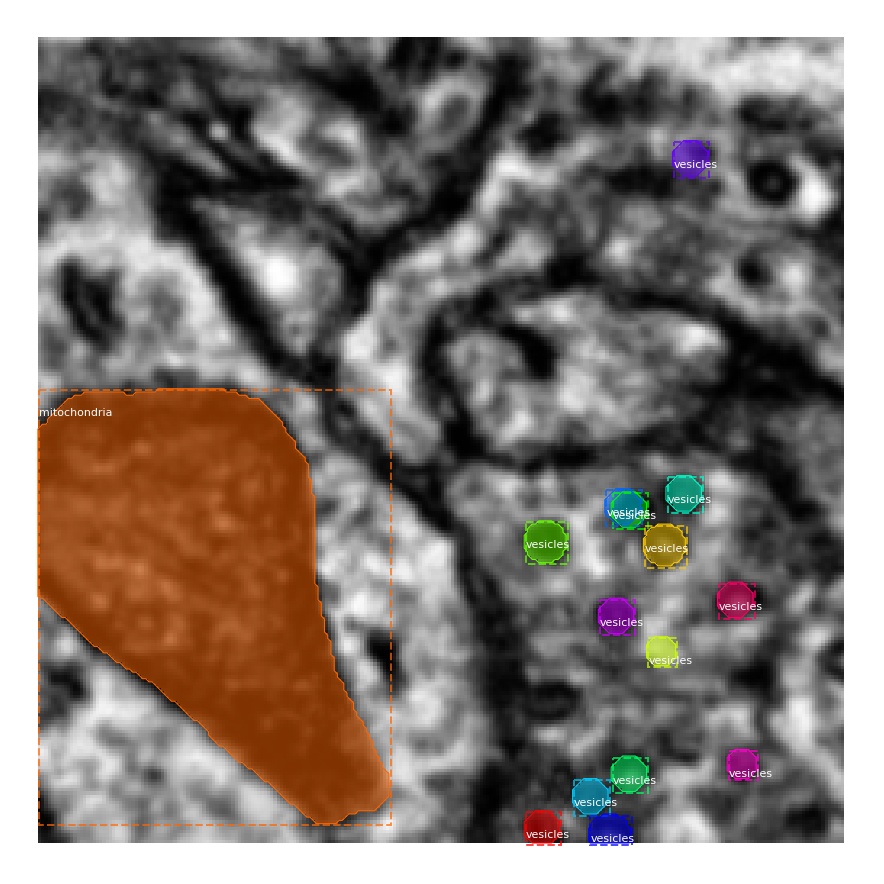

In [19]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
plt.draw()
plt.savefig('/home/parastooj/VesicleSegmentation/image/annotation_result.png')


image                    shape: (250, 250, 3)         min:    1.00000  max:  249.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  250.00000  int64
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:   28.00000  max:  219.00000  int32
mask                     shape: (250, 250, 3)         min:    0.00000  max:    1.00000  bool


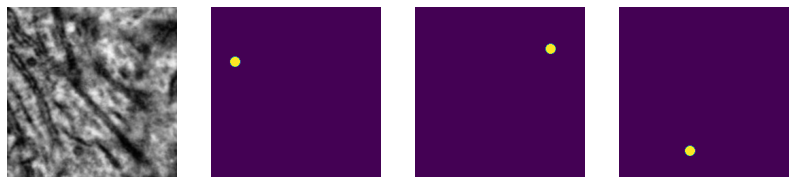

In [20]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

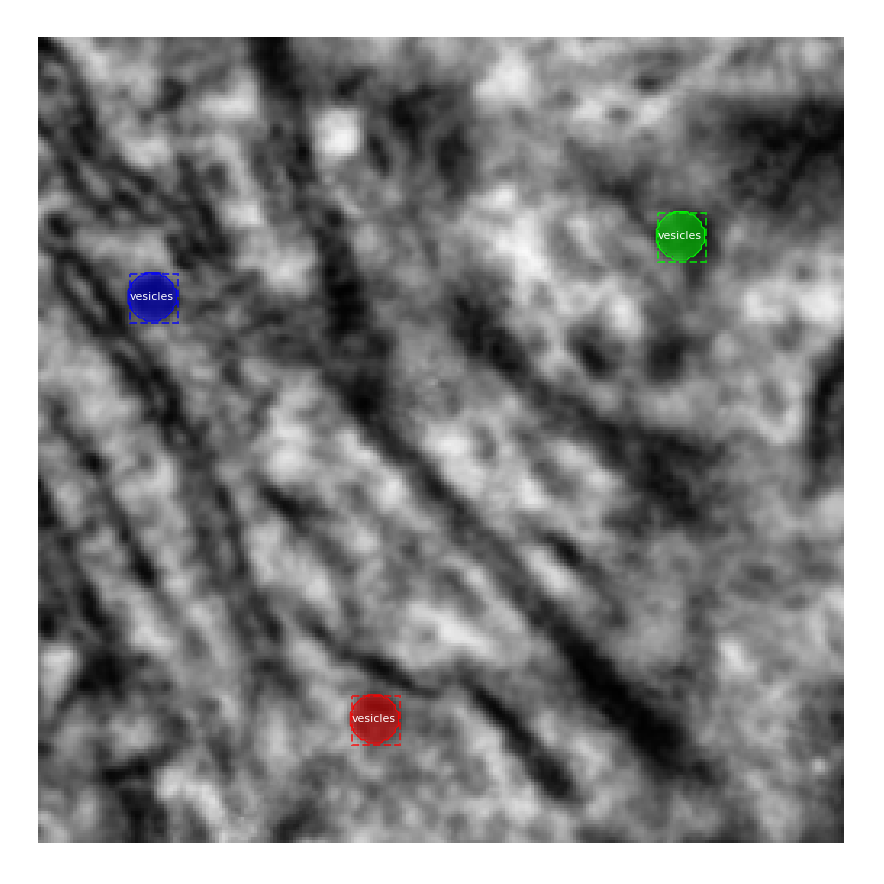

In [21]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 3)           min:    0.00000  max:    1.00000  bool


/home/parastooj/anaconda3/envs/rcnn/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


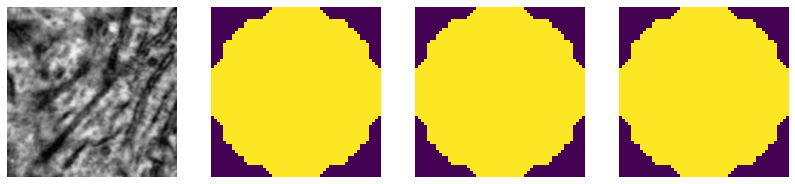

In [22]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

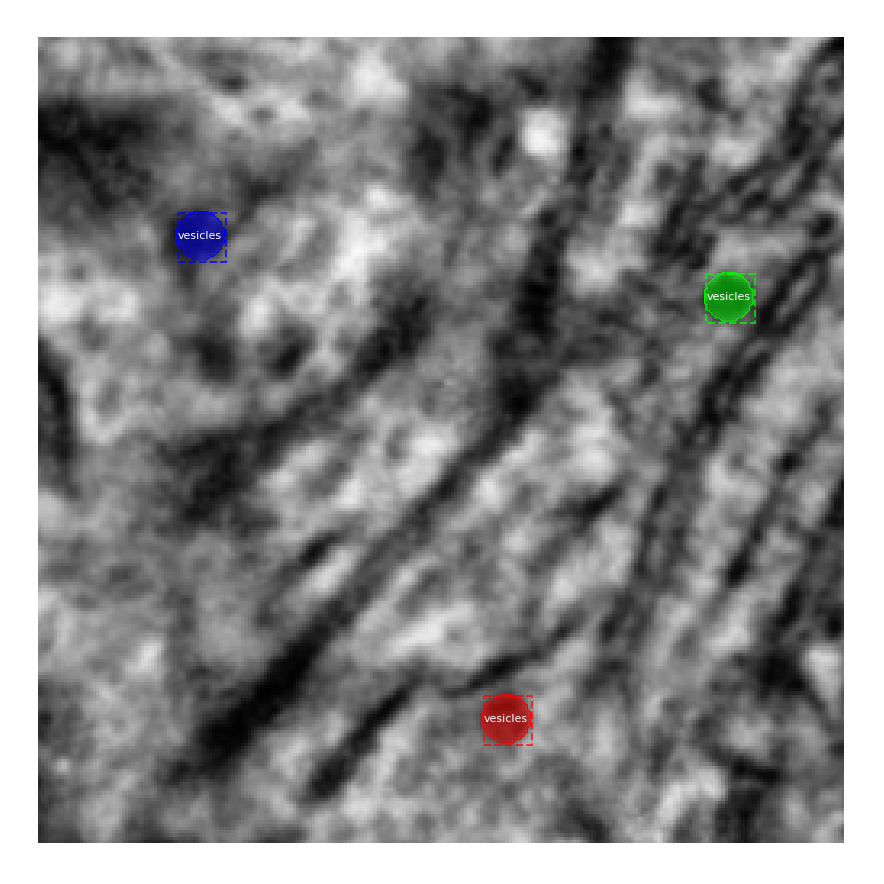

In [23]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Count:  16368
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48
Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


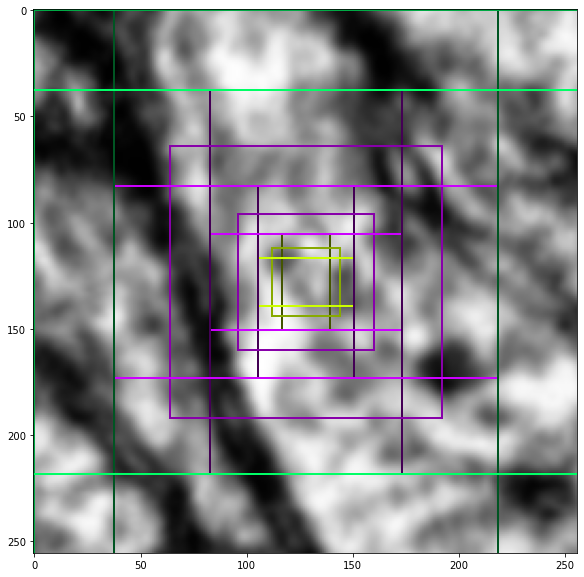

In [24]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, crop_config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, crop_config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))